# Process the output of the simulation

(This can be required if the sensitivity curve does not form a single connected (but possibly open) path.)

List the currently-installed packages (for reproducibility).

In [1]:
]st

Status `~/Documents/Research/Projects/SensCalc/Code/SensMC/Project.toml`
⌃ [336ed68f] CSV v0.10.8
⌃ [a93c6f00] DataFrames v1.4.4
  [864edb3b] DataStructures v0.18.13
⌃ [31c24e10] Distributions v0.25.86
⌃ [e9467ef8] GLMakie v0.8.2
⌃ [5c1252a2] GeometryBasics v0.4.6
  [7073ff75] IJulia v1.24.0
⌃ [682c06a0] JSON v0.21.3
  [3f54b04b] LorentzVectors v0.4.3
  [ea0cff06] MDBM v0.1.6 `https://github.com/JLTastet/MDBM.jl#3788144`
⌅ [ee78f7c6] Makie v0.19.2
  [c03570c3] Memoize v0.4.4
  [e1d29d7a] Missings v1.1.0
  [3b2b4ff1] Multisets v0.4.4
⌃ [bac558e1] OrderedCollections v1.4.1
  [c46f51b8] ProfileView v1.7.1
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
⌃ [f2b01f46] Roots v2.0.10
⌃ [90137ffa] StaticArrays v1.5.18
⌅ [2913bbd2] StatsBase v0.33.21
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
  [1a1011a3] SharedArrays
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status 

Include the snapshots of the relevant scripts (once again for reproducibility).

In [2]:
include("$(@__DIR__)/../lib/IncludeAll.jl");
include("$(@__DIR__)/../scripts/GenerateEvents.jl");
include("$(@__DIR__)/../scripts/ScanSensitivity.jl");

  Activating project at `~/Documents/Research/Projects/SensCalc/Code/SensMC`


In [3]:
data_dir = "$(@__DIR__)/../tables/sensitivity/MATHUSLA";

In [4]:
using DataFrames
using CSV
using Printf
using PyPlot
PyPlot.svg(true)
using Random
Random.seed!(25269);

In [5]:
function read_sensitivity(root, name)
    df_sol = CSV.read(joinpath(root, "$(name).csv"), DataFrame)
    df_ct  = CSV.read(joinpath(root, "$(name)_connection.csv"), DataFrame)
    edges = tuple.(df_ct[:,1], df_ct[:,2]);
    open_loops, closed_loops = find_loops(edges)
    curves = [(df_sol[perm,1], df_sol[perm,2]) for perm in vcat(open_loops, closed_loops)]
end

read_sensitivity (generic function with 1 method)

Plot the sensitivity along with the one obtained by Maksym, as a last cross-check.

In [6]:
function make_plot(; title="", xlabel=L"m_S\;[\mathrm{GeV}]", ylabel=L"\theta^2", figsize=(6.4, 4.8), grid=true)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_yscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);
    if grid
        ax.grid(color="gray", linestyle=":")
    end
    ax.autoscale()
    ax.set_title(title, fontsize=10)
    fig, ax
end

make_plot (generic function with 1 method)

In [7]:
function plot_sensitivity!(ax, root, name; label="", square=false, style...)
    curves = read_sensitivity(root, name)
    xs, ys = [], []
    for (i, curve) in enumerate(curves)
        lb = if i == 1; label else; "" end
        x, y = curve
        y = square ? y .^2 : y
        ax.plot(x, y, label=lb; style...)
        push!(xs, x)
        push!(ys, y)
    end
    xs, ys
end

plot_sensitivity! (generic function with 1 method)

In [8]:
function plot_reference_sensitivity!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; linewidth=linewidth, style...)
end

plot_reference_sensitivity! (generic function with 1 method)

In [9]:
function plot_excluded_region!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; color="black", linewidth=linewidth, style...)
    ax.fill(df[:,1], y; color="lightgrey", style...)
end

plot_excluded_region! (generic function with 1 method)

#### Produce the plot for the paper

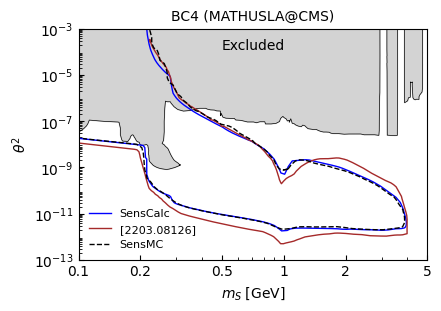

In [10]:
fig, ax = make_plot(title="BC4 (MATHUSLA@CMS)", figsize=(4.5,3), grid=false)
plot_excluded_region!(ax, joinpath(data_dir, ".."), "scalar-all-experiments.txt"; header=["mS", "theta"], linewidth=0.5)
plot_reference_sensitivity!(ax, data_dir, "Sensitivity_Scalar_at_MATHUSLA_BrhToSS=0._Nev=2.3.dat"; header=["mS", "theta"], label="SensCalc", color="blue")
plot_reference_sensitivity!(ax, data_dir, "BC4-MATHUSLACMS.txt"; header=["mS", "theta"], label="[2203.08126]", color="brown")
mS, θ² = plot_sensitivity!(ax, data_dir, "MATHUSLA_scalar_sensitivity_CL90", label="SensMC", color="black", linestyle="--", square=true, linewidth=1)
ax.set_xscale("log")
ax.autoscale()
ax.set_xlim(left=0.1, right=5)
ax.set_ylim(top=1e-3, bottom=1e-13)
xticks = [0.1, 0.2, 0.5, 1, 2, 5]
ax.set_xticks(xticks)
ax.set_xticklabels([@sprintf("%.1g", x) for x in xticks])
ax.legend(loc="lower left", frameon=false, fontsize=8)
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.tick_params(axis="both", which="both", direction="in")
#ax.text(0.83, 0.61, "CL = 0.9", fontsize=10, transform=ax.transAxes, ha="center", va="top")
ax.text(0.5, 0.96, "Excluded", fontsize=10, transform=ax.transAxes, ha="center", va="top")
nothing

In [11]:
fig.savefig("$(@__DIR__)/../plots/MATHUSLA_scalar_sensitivity_CL90.pdf", bbox_inches="tight")

#### Process and save the actual sensitivity curve

Extract the relevant loop(s).

In [12]:
mS

3-element Vector{Any}:
 [1.0475095620278927, 0.9909558457220665]
 [1.0475095620278927, 0.9909558457220665, 0.9497568000904238, 0.9145052524262925, 0.8921383108644644, 0.8519787772093556, 0.8382970676160468, 0.8016992431027271, 0.7684493578530855, 0.7246649424598497  …  0.2420133017729092, 0.23241065980319908, 0.2274207749397619, 0.22725047721405836, 0.22383557751320585, 0.2208044804110624, 0.21097190236471103, 0.20862704140058239, 0.20862704140039534, 0.20862704139891328]
 [1.0475095620278927, 1.0871306906637264, 1.1391592900269012, 1.18135315959453, 1.270830143988639, 1.3190869569798462, 1.406621657033197, 1.523816314256781, 1.656881872378224, 1.7654143443960493  …  0.20327915068404895, 0.19239723576256915, 0.19026977663165534, 0.17476144745495853, 0.16055824516195005, 0.14748123830742502, 0.13546871075526398, 0.12443958876892584, 0.1143247283527619, 0.10505469141159955]

In [13]:
print([length(piece) for piece in mS])

[2, 48, 87]

The array looks like it isn’t connected well due to noise. Since there are only a few pieces, let’s connect them by hand. To this end, let’s drop the small loop and connect the big pieces together.

In [14]:
zip(mS[2], θ²[2]) |> collect

48-element Vector{Tuple{Float64, Float64}}:
 (1.0475095620278927, 8.35562865387652e-10)
 (0.9909558457220665, 7.699134160399648e-10)
 (0.9497568000904238, 8.647434975384217e-10)
 (0.9145052524262925, 1.3538337984349644e-9)
 (0.8921383108644644, 2.2896955904449583e-9)
 (0.8519787772093556, 3.3155110351847785e-9)
 (0.8382970676160468, 4.356443047454134e-9)
 (0.8016992431027271, 6.101708018004447e-9)
 (0.7684493578530855, 7.962286505281787e-9)
 (0.7246649424598497, 1.089227846762942e-8)
 (0.7066439662236373, 1.4078673705540591e-8)
 (0.689618311112592, 1.6287413306239122e-8)
 (0.6410800927931902, 2.342380417365421e-8)
 ⋮
 (0.24936452858689778, 4.282889025116281e-5)
 (0.24641812905564123, 7.52449380566177e-5)
 (0.2420133017729092, 0.00011322851611990768)
 (0.23241065980319908, 0.00015119461401023995)
 (0.2274207749397619, 0.00023713498022164337)
 (0.22725047721405836, 0.00042166441747200085)
 (0.22383557751320585, 0.000720001384869763)
 (0.2208044804110624, 0.001047996925928395)
 (0.2109719

In [15]:
zip(mS[3], θ²[3]) |> collect

87-element Vector{Tuple{Float64, Float64}}:
 (1.0475095620278927, 8.35562865387652e-10)
 (1.0871306906637264, 1.3039861826698041e-9)
 (1.1391592900269012, 1.890166431479458e-9)
 (1.18135315959453, 2.136040432908329e-9)
 (1.270830143988639, 2.0456739702123945e-9)
 (1.3190869569798462, 1.868050379031301e-9)
 (1.406621657033197, 1.5288936998462687e-9)
 (1.523816314256781, 1.296748811999206e-9)
 (1.656881872378224, 1.1105974085443988e-9)
 (1.7654143443960493, 9.31644573958657e-10)
 (1.8293030438464128, 8.573211651281121e-10)
 (1.9738961879438799, 7.158939987751164e-10)
 (2.106638258944108, 5.864300574633647e-10)
 ⋮
 (0.20820750707780206, 2.3698446426660785e-9)
 (0.20679135224074768, 4.1921087089336345e-9)
 (0.20327915068404895, 7.220730427073443e-9)
 (0.19239723576256915, 9.959428781018656e-9)
 (0.19026977663165534, 1.0056223454931168e-8)
 (0.17476144745495853, 1.0948752456383352e-8)
 (0.16055824516195005, 1.1874478065085831e-8)
 (0.14748123830742502, 1.2822705382421728e-8)
 (0.13546871075

Create a data frame containing the curve.

In [16]:
df = DataFrame(
    mS = vcat(reverse(mS[3]), mS[2]),
    theta2 = vcat(reverse(θ²[3]), θ²[2])
)

Row,mS,theta2
,Float64,Float64
1,0.105055,1.77233e-8
2,0.114325,1.62408e-8
3,0.12444,1.49671e-8
4,0.135469,1.38419e-8
5,0.147481,1.28227e-8
6,0.160558,1.18745e-8
7,0.174761,1.09488e-8
8,0.19027,1.00562e-8
9,0.192397,9.95943e-9


Let’s check that it plots correctly.

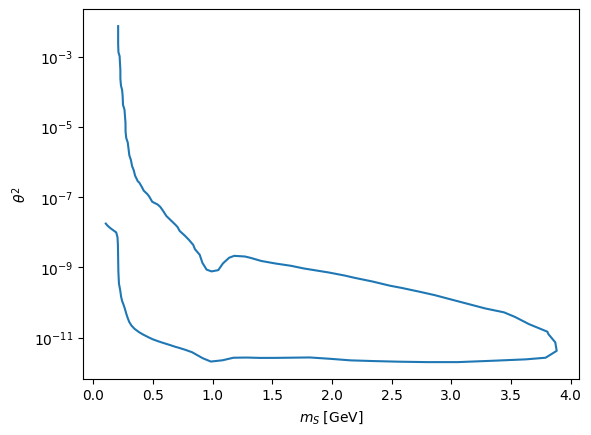

In [17]:
plt.plot(df.mS, df.theta2)
plt.yscale("log")
plt.xlabel(raw"$m_S\;[\mathrm{GeV}]$")
plt.ylabel(raw"$\theta^2$");

Looks good. Let’s save the final curve.

In [18]:
CSV.write(joinpath(data_dir, "MATHUSLA_scalar_sensitivity_curve_CL90.csv"), df)

"/Users/jl/Documents/Research/Projects/SensCalc/Code/SensMC/notebooks/../tables/sensitivity/MATHUSLA/MATHUSLA_scalar_sensitivity_curve_CL90.csv"